<a href="https://colab.research.google.com/github/Atabak-Touri/forecasting-model/blob/main/timeseriesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install utilsforecast
!pip install utilforecast
!pip install statsforecast

ERROR: Could not find a version that satisfies the requirement utilforecast (from versions: none)
ERROR: No matching distribution found for utilforecast


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#plotting our series and evaluating them, using different metrics:
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings('ignore')


In [6]:
df = pd.read_csv("sample_data/daily_sales_french_bakery.csv")
df = df.groupby("unique_id").filter(lambda x: len(x) >= 28) #filtering series that have more than 28 timesteps
df.head()

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0


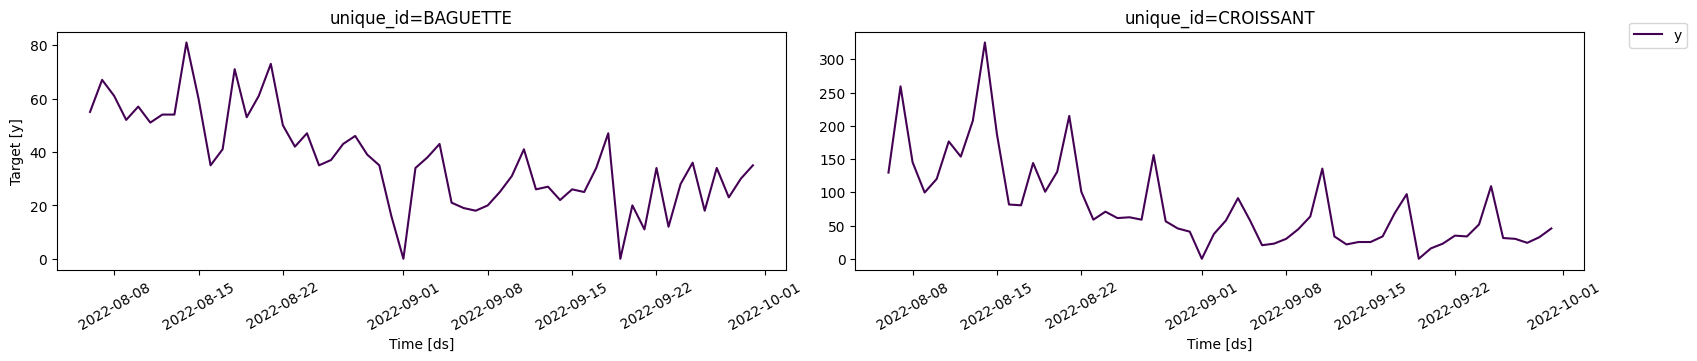

In [7]:
df['ds'] = pd.to_datetime(df['ds'])
plot_series(df=df , ids=["BAGUETTE", "CROISSANT"], max_insample_length=56, palette="viridis")
#max_insample_length selects the last 56 time steps

In [8]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [9]:
horizon= 7 #next 7 days

models=[
    Naive(),#forecast the last known timestep
    HistoricAverage(),#forecast the average of entire history
    WindowAverage(window_size=7),#forecast the average of how many timesteps you want to forecast
    SeasonalNaive(season_length= 7 )
]

sf= StatsForecast(models= models, freq="D")
sf.fit(df=df)
preds= sf.predict(h=horizon)

In [10]:
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0


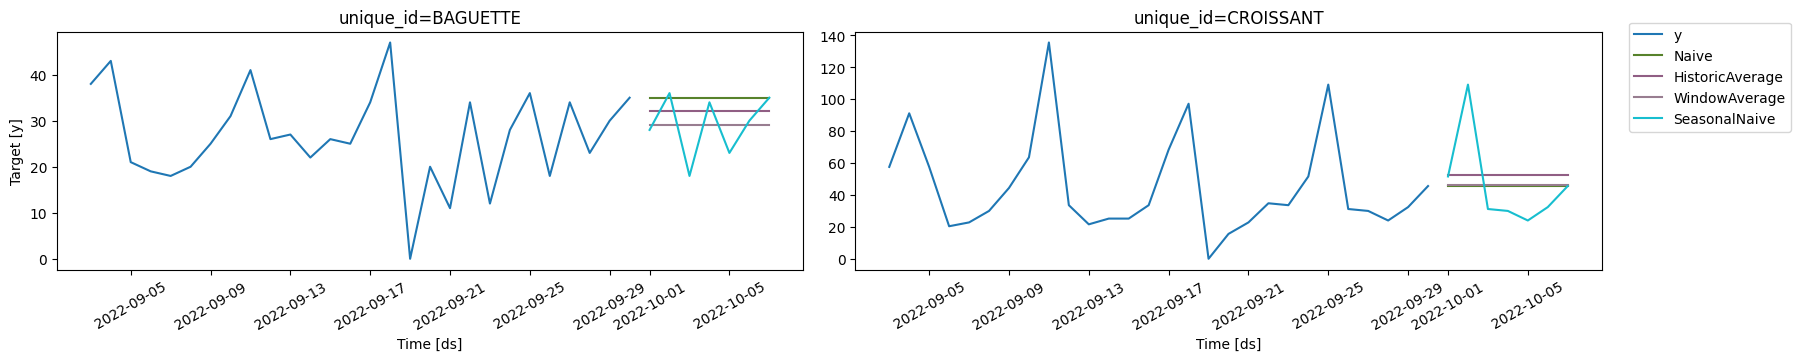

In [11]:
plot_series(
    df=df,
    forecasts_df=preds,
    ids=["BAGUETTE", "CROISSANT"],
    max_insample_length=28,
)

This is the very first forecast, but we don't know how these models are performing as we just predictiong the future which we don't know the actual value. so we need to do a test train split.

In [12]:
test = df.groupby("unique_id").tail(7) #taking the last 7 timesteps as a test set
train= df.drop(test.index).reset_index(drop=True) #train will be the rest of that

In [13]:
sf.fit(df=train)
preds= sf.predict(h=horizon)
eval_df= pd.merge(test,preds,"left",["ds","unique_id"]) #evaluation dataframe

In [14]:
evaluation=evaluate(
    eval_df,
    metrics =[mae]
)
evaluation.head()

,unique_id,metric,unit_price,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,7.142857,2.857143,6.961771,3.469388,4.285714
1,BAGUETTE,mae,28.142857,17.142857,5.455193,7.877551,12.571429
2,BAGUETTE APERO,mae,4.500000,0.000000,0.537572,0.642857,0.642857
3,BAGUETTE GRAINE,mae,2.800000,9.800000,4.612271,2.942857,0.200000
4,BANETTE,mae,32.035714,1.314286,5.421984,6.008163,7.885714


after inspecting, we have the MAE for each series for each method.
so it is interesting to get average across all the series as follow:

In [15]:
evaluation=evaluation.drop(["unique_id"], axis=1).groupby("metric").mean().reset_index()
evaluation

,metric,unit_price,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,8.959917,6.107556,5.228439,5.011663,4.613636


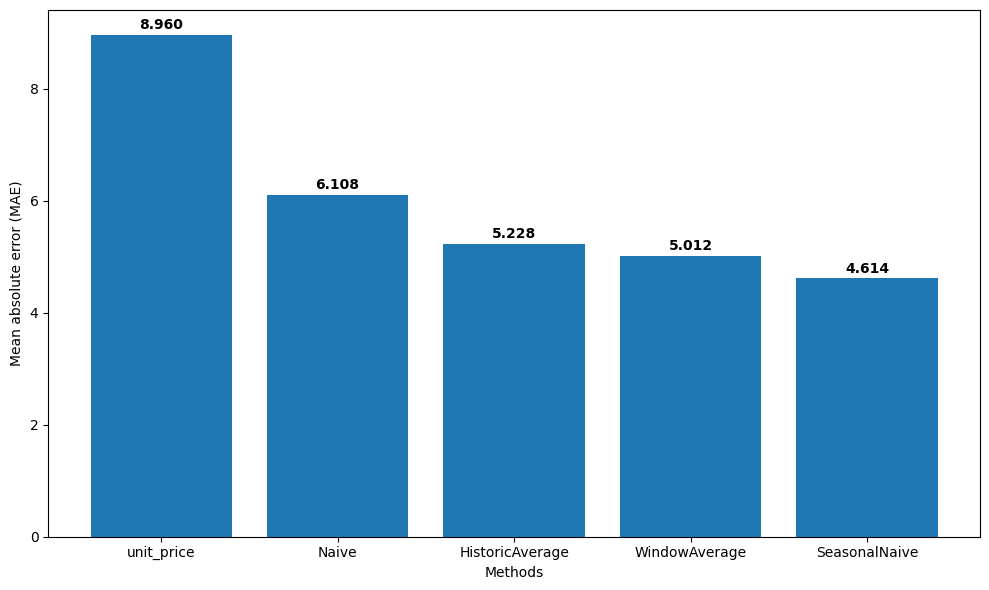

In [16]:
methods = evaluation.columns[1:].tolist()
values = evaluation.iloc[0, 1:].tolist()

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, values)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

as it can be seen the seasonal Naive acheieve the lowest MAE across all series, as our series have seasonality. so utilizing seasonalNaive for seasonal data is usually the best baseline.
**Generally, the lower the Mean Absolute Error (MAE), the better your model is at fitting the dataset and making accurate predictions. MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It's simply the average of the absolute differences between the predicted values and the actual values. A lower MAE means that, on average, your model's predictions are closer to the actual values.**




---
so far I've used Python to forecast using baseline models and now it's time to try out more advanced model


---





In [17]:
from statsforecast.models import AutoARIMA, AutoCES

In [24]:
unique_ids = ["BAGUETTE", "CROISSANT"]

small_train = train[train["unique_id"].isin(unique_ids)]
small_test = test[test["unique_id"].isin(unique_ids)]

models = [
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=small_train)

X_df_predict = small_test[['unique_id', 'ds', 'unit_price']]

arima_preds = sf.predict(h=horizon, X_df=X_df_predict)

arima_eval_df = pd.merge(arima_preds, eval_df, 'inner', ['ds', 'unique_id'])
arima_eval = evaluate(
    arima_eval_df,
    metrics=[mae]
)
arima_eval

,unique_id,metric,ARIMA,SARIMA,unit_price,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BAGUETTE,mae,9.354474,7.363290,28.142857,17.142857,5.455193,7.877551,12.571429
1,CROISSANT,mae,14.780113,10.367782,45.085714,17.485714,22.618934,18.244898,12.857143


In [25]:
arima_eval = arima_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
arima_eval

,metric,ARIMA,SARIMA,unit_price,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,12.067293,8.865536,36.614286,17.314286,14.037063,13.061224,12.714286


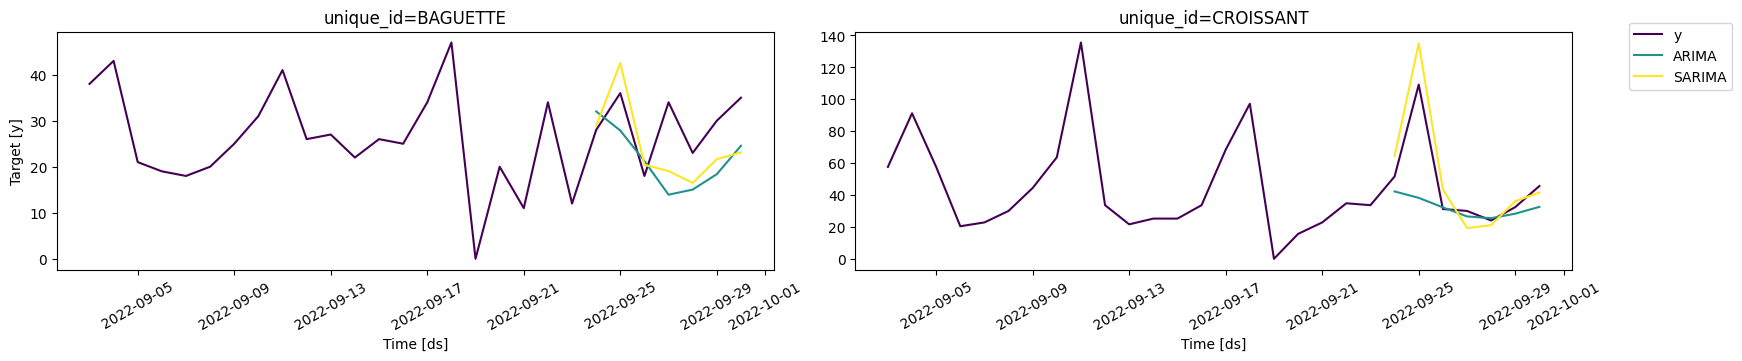

In [26]:
plot_series(
    df=df,
    forecasts_df=arima_preds,
    ids=["BAGUETTE", "CROISSANT"],
    max_insample_length=28,
    palette="viridis")

it can be seen with SARIMA we get better results as for ARIMA it is struggling but on the other hand SARIMA is giving us much better forecast

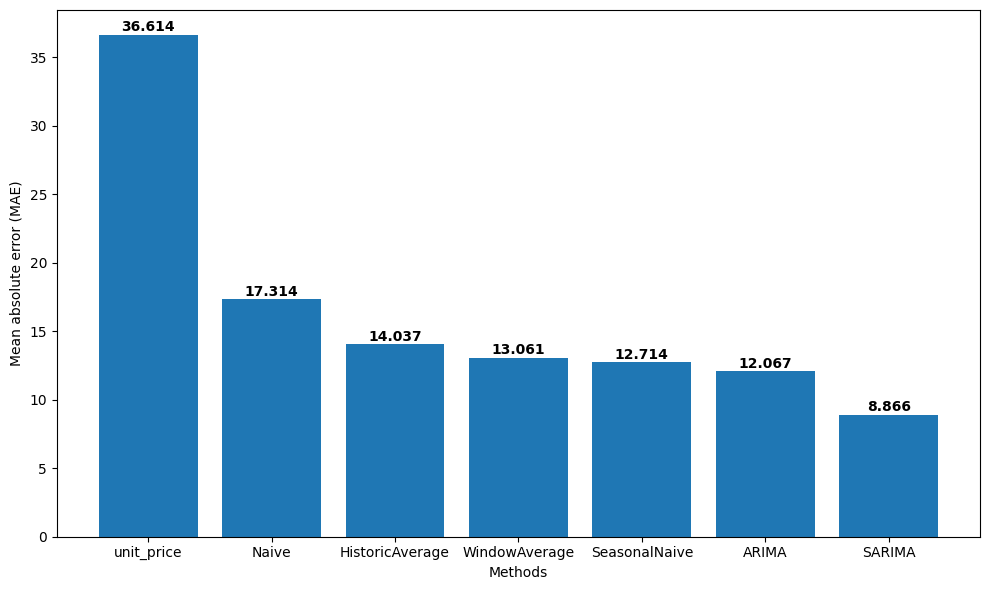

In [27]:
methods = arima_eval.columns[1:].tolist()
values = arima_eval.iloc[0, 1:].tolist()

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

Cross-Validation
we don't need train test splits anymore because we're going to use windows of forecast to make evaluation of our model.

In [32]:
small_df = df[df["unique_id"].isin(unique_ids)]

models= [
    SeasonalNaive(season_length= 7), #as it is the best benchmark
    AutoARIMA(seasonal=False, alias = "ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf= StatsForecast(models=models, freq="D")

cv_df= sf.cross_validation(
    h= horizon,
    df= small_df, #passing dataframe, entire
    n_windows = 8, #with horizon of7, we have 8 windows of 7 forecast. 8*7 = 56. we get more than 50 points which is a reasonable sample size to evalute our prediction
    step_size= horizon,
    refit=True, #it defines if we want to reoptimize our model everytime the input size changes. if the model is updated everytime we forecast and we're going to get new actual data then we need this parameter. but if you think that you're going to train your model once and it will change after 3-4 months then put it in production set it to false
)
cv_df.head()


,unique_id,ds,cutoff,y,SeasonalNaive,ARIMA,SARIMA
0,BAGUETTE,2022-08-06,2022-08-05,55.0,68.0,71.362604,71.511528
1,BAGUETTE,2022-08-07,2022-08-05,67.0,70.0,70.357892,78.458054
2,BAGUETTE,2022-08-08,2022-08-05,61.0,48.0,61.200004,57.062745
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.0,52.644621,49.525901
4,BAGUETTE,2022-08-10,2022-08-05,57.0,57.0,47.770610,49.485683


cutoff is where the model stopped training.

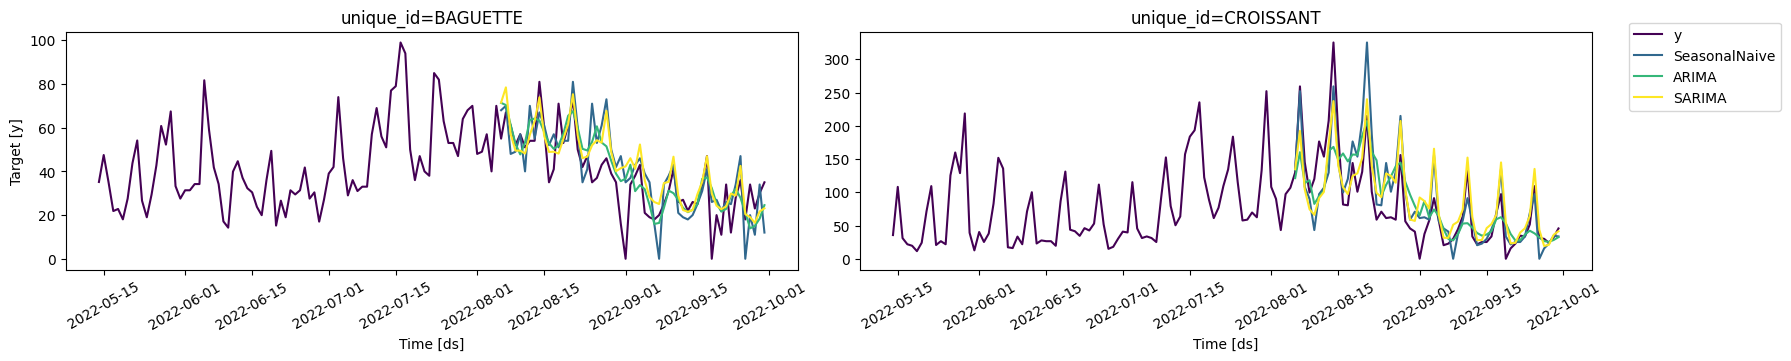

In [33]:
plot_series(
    df=small_df,
    forecasts_df=cv_df.drop(["y", "cutoff"], axis=1),
    ids=["BAGUETTE", "CROISSANT"],
    max_insample_length=140,
    palette="viridis")

In [35]:
cv_eval = evaluate(
    cv_df.drop(["cutoff"], axis=1),
    metrics= [mae],
)
cv_eval = cv_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_eval

,metric,SeasonalNaive,ARIMA,SARIMA
0,mae,21.117857,21.767229,19.211687


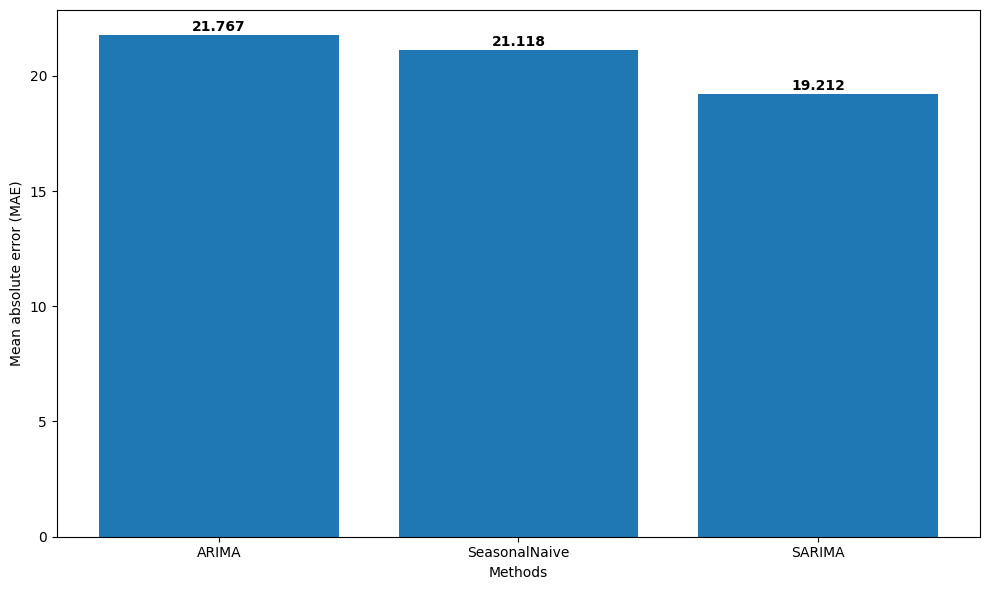

In [36]:
methods = cv_eval.columns[1:].tolist()
values = cv_eval.iloc[0, 1:].tolist()

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

ARIMA is worst than seasonalNaive!
this is the importance of cross validation because before that we thought that ARIMA is better than seasonalNaive.
However SARIMA is still better than bth of them.